In [5]:
import torch
from torch import nn



In [43]:
from torch import nn

print1Q = False
#print1Q = True

# Creating a CNN class
class ShallowConvNet(nn.Module):
#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes=40, C=64, T=1250, F1=8, D=2, F2=16, dropout_prob=0.5, Wt=64, Ws=16, pool1=4, pool2=8):
        """
        Args:
            num_classes: Number of output classes (default=40).
            C: Number of EEG channels (default=64).
            T: Number of time points (default=1250).
            F1: Number of temporal filters (default=8).
            D: Depth multiplier for depthwise conv (default=2).
            F2: Number of separable spatial filters (default=16).
            dropout_prob: Dropout probability (default=0.5).
            Wt: width of time kernel
            Ws: width of space kernel
            pool1: width of block 1 pool kernel
            pool2: width of block 2 pool kernel
        """
        super(ShallowConvNet, self).__init__()

        # Block 1: Temporal Convolution
        self.block1 = nn.Sequential(
            nn.Conv2d(1, F1, kernel_size=(1, Wt), padding='same', bias=False),  # Temporal Conv
            nn.BatchNorm2d(F1),
            nn.Conv2d(F1, F1 * D, kernel_size=(C, 1), bias=False, groups=D),
            nn.BatchNorm2d(F1 * D),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, pool1)),
            nn.Dropout(p=dropout_prob)
        )
        
        # Block 2: Separable Convolution
        self.block2 = nn.Sequential(
            nn.Conv2d(F1 * D, F2, kernel_size=(1, Ws), padding='same', bias=False),  # Depthwise Separable Conv
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, pool2)),
            nn.Dropout(p=dropout_prob)
        )
        
        # Fully Connected Layer
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(F2 * (T // (pool1*pool2)), num_classes),  # Adjust based on the pooling
            nn.Softmax(dim=1)
        )

    
    # Progresses data across layers    
    def forward(self, x):
        if(print1Q): print("input, ", x.shape)
        x = x.unsqueeze(1) # Add channel dimension: [batch, 1, 64, 1500]
        if(print1Q): print("input2, ", x.shape)
        x = self.block1(x)
        if(print1Q): print(x.shape)
        x = self.block2(x)
        if(print1Q): print(x.shape)
        x = self.fc(x)
        if(print1Q): print(x.shape)
        return x

In [44]:

print1Q = False
#print1Q = True

class Simple3conv(nn.Module):
    def __init__(self, input_length=1250, num_classes=40, num_channels=64, F1=8, groups=8, F2=16, F3=32, dropout_prob=0.5, Wt=125, Ws=16, pool1=4):
        """
        Args:
            num_classes: Number of output classes (default=40).
            C: Number of EEG channels (default=64).
            T: Number of time points (default=1250).
            F1: Number of temporal filters (default=8).
            D: Depth multiplier for depthwise conv (default=2).
            F2: Number of separable spatial filters (default=16).
            dropout_prob: Dropout probability (default=0.5).
            Wt: width of time kernel
            Ws: width of space kernel
            pool1: width of block 1 pool kernel
            pool2: width of block 2 pool kernel
        """
        super(Simple3conv, self).__init__()

        # Temporal Convolution to focus on the band of interest
        self.temporal_conv = nn.Sequential(
            nn.Conv2d(1, F1, (1, Wt), stride=(1, 2), padding=(0, (Wt-1)//2), bias=False),  # Filter ~2-20Hz
            nn.BatchNorm2d(F1),
            nn.ELU(),
            nn.Dropout(p=dropout_prob)
        )

        # Depthwise Convolution for spatial filtering
        self.spatial_conv = nn.Sequential(
            nn.Conv2d(F1, F2, (num_channels, 1), groups=groups, bias=False),  # Depthwise
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.Dropout(p=dropout_prob)
        )

        # Separable Convolution for extracting temporal features
        self.temporal_separable = nn.Sequential(
            nn.Conv2d(F2, F3, (1, F2), stride=(1, 2), padding=(0, F2//2), bias=False),  # Temporal separable
            nn.BatchNorm2d(F3),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),  # Reduce temporal dimension,
            nn.Dropout(p=dropout_prob)
        )

        # Classification Head
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(F3 * (input_length // (pool1*2*2)), num_classes*2),  # Adapt to temporal dimension
            nn.ReLU(),
            nn.Linear(num_classes*2, num_classes),  # Adapt to temporal dimension
            nn.Softmax(dim=1)
        )


    def forward(self, x):
        if(print1Q): print("input, ", x.shape)
        x = x.unsqueeze(1) # Add channel dimension: [batch, 1, 64, 1500]
        if(print1Q): print("input2, ", x.shape)
        x = self.temporal_conv(x)
        if(print1Q): print(x.shape)
        x = self.spatial_conv(x)
        if(print1Q): print(x.shape)
        x = self.temporal_separable(x)
        if(print1Q): print(x.shape)
        x = self.fc(x)
        if(print1Q): print(x.shape)
        return x

In [47]:

SOURCEFOLDER = "D:\\Universidade\\DTU 1A 2S fall\\BCI\\SSVEP-BCI-Data\\SSVEP-BCI-Data\\"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Simple3conv(num_classes=40, F1=16, F2=32, F3=40, dropout_prob=0.5).to(device)
model = torch.load(SOURCEFOLDER + "model1.pt", weights_only=False)
print(model)

for p in model.parameters():
    print(p.name, " | ", p.shape)

Simple3conv(
  (temporal_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 125), stride=(1, 2), padding=(0, 62), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.5, inplace=False)
  )
  (spatial_conv): Sequential(
    (0): Conv2d(8, 16, kernel_size=(64, 1), stride=(1, 1), groups=8, bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.5, inplace=False)
  )
  (temporal_separable): Sequential(
    (0): Conv2d(16, 32, kernel_size=(1, 16), stride=(1, 2), padding=(0, 8), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.5, inplace=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2496, out_f

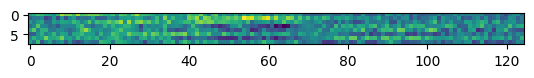

In [48]:
from matplotlib import pyplot as plt
plt.imshow(model.temporal_conv[0].weight.cpu().detach().numpy()[:,0,0,:], interpolation='nearest')
plt.show()

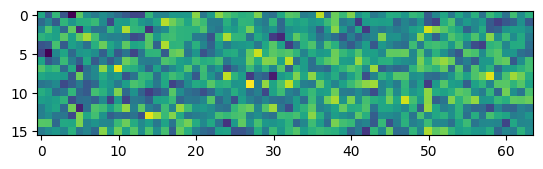

In [49]:

plt.imshow(model.spatial_conv[0].weight.cpu().detach().numpy()[:,0,:,0], interpolation='nearest')
plt.show()

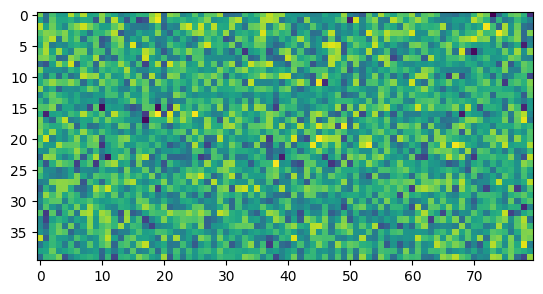

In [51]:

plt.imshow(model.fc[3].weight.cpu().detach().numpy(), interpolation='nearest')
plt.show()

---

In [45]:

SOURCEFOLDER = "D:\\Universidade\\DTU 1A 2S fall\\BCI\\SSVEP-BCI-Data\\SSVEP-BCI-Data\\"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ShallowConvNet(num_classes=40).to(device)
model = torch.load(SOURCEFOLDER + "model1_.pt", weights_only=False)
print(model)

for p in model.parameters():
    print(p.name, " | ", p.shape)

ShallowConvNet(
  (block1): Sequential(
    (0): Conv2d(1, 12, kernel_size=(1, 64), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(12, 48, kernel_size=(64, 1), stride=(1, 1), groups=4, bias=False)
    (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (6): Dropout(p=0.5, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(48, 24, kernel_size=(1, 16), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.5, inplace=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1872, out_features=40, bias=True)
    (2): Softmax(dim=1)
  )


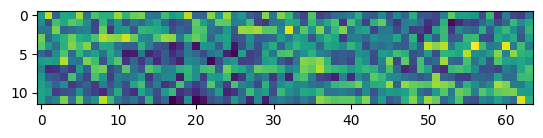

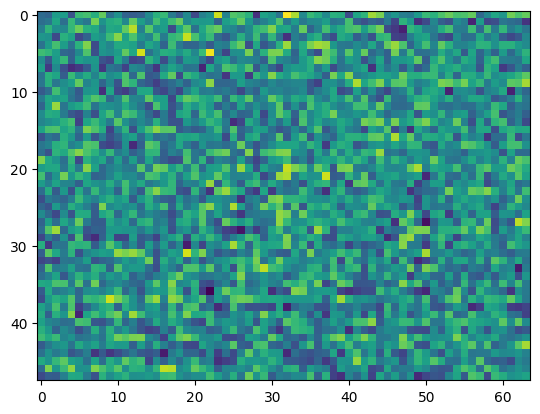

In [46]:
from matplotlib import pyplot as plt
plt.imshow(model.block1[0].weight.cpu().detach().numpy()[:,0,0,:], interpolation='nearest')
plt.show()

plt.imshow(model.block1[2].weight.cpu().detach().numpy()[:,0,:,0], interpolation='nearest')
plt.show()